# Systematic Literature Review DX in Shipping - Co-Authorship analysis

In [129]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # Correct import
from collections import Counter
import numpy as np
import powerlaw
import holoviews as hv
from holoviews import opts
from collections import defaultdict

## Read the DB in

In [3]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [5]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'author_id'
# List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k]
#matching_columns.remove('referenced_works_count')
print(matching_columns)
#print(lit['authorships_0_author_id'])
#print(lit['id'])

['authorships_0_author_id', 'corresponding_author_ids_0', 'authorships_1_author_id', 'authorships_2_author_id', 'authorships_3_author_id', 'authorships_4_author_id', 'corresponding_author_ids', 'authorships_5_author_id', 'authorships_6_author_id', 'corresponding_author_ids_1', 'authorships_7_author_id', 'authorships_8_author_id', 'authorships_9_author_id', 'authorships_10_author_id', 'authorships_11_author_id', 'authorships_12_author_id', 'authorships_13_author_id', 'authorships_14_author_id', 'authorships_15_author_id', 'authorships_16_author_id', 'authorships_17_author_id', 'authorships_18_author_id', 'authorships_19_author_id', 'authorships_20_author_id', 'authorships_21_author_id', 'authorships_22_author_id', 'authorships_23_author_id', 'authorships_24_author_id', 'authorships_25_author_id', 'authorships_26_author_id', 'authorships_27_author_id', 'authorships_28_author_id', 'authorships_29_author_id', 'authorships_30_author_id', 'authorships_31_author_id', 'authorships_32_author_id

In [7]:
# First we need to identiy all available authors

authors_list = []

for index, row in lit.iterrows():
    for c in matching_columns:
        if not pd.isnull(row[c]) and not '_ids' in c and not 'corresponding' in c:
            if not row[c] in authors_list:
                authors_list.append(row[c])

In [9]:
print(len(authors_list))
#authors_list

7723


In [125]:
# Let's build the graph of co-authorship

G = nx.Graph()

for index, row in lit.iterrows():
    for cfirst in matching_columns:
        if not '_ids' in cfirst and not 'corresponding' in cfirst and not pd.isnull(row[cfirst]):
            for csecond in matching_columns:
                if not '_ids' in csecond and not 'corresponding' in csecond and not pd.isnull(row[csecond]):
                    if cfirst != csecond: # we don't link an author to itself
                        firstCountryVal = row.get(cfirst.split('_')[0] + '_' + cfirst.split('_')[1] + '_institutions_0_country_code','NaN')                        
                        secondCountryVal = row.get(csecond.split('_')[0] + '_' + csecond.split('_')[1] + '_institutions_0_country_code', 'NaN')
                        firstInstVal = row.get(cfirst.split('_')[0] + '_' + cfirst.split('_')[1] + '_institutions_0_display_name','NaN')                        
                        secondInstVal = row.get(csecond.split('_')[0] + '_' + csecond.split('_')[1] + '_institutions_0_display_name', 'NaN')
                        G.add_edge(row[cfirst], row[csecond], firstCountry = firstCountryVal, secondCountry = secondCountryVal, firstInstitute = firstInstVal , secondInstitute = secondInstVal)

In [13]:
print(G.number_of_nodes())

7550


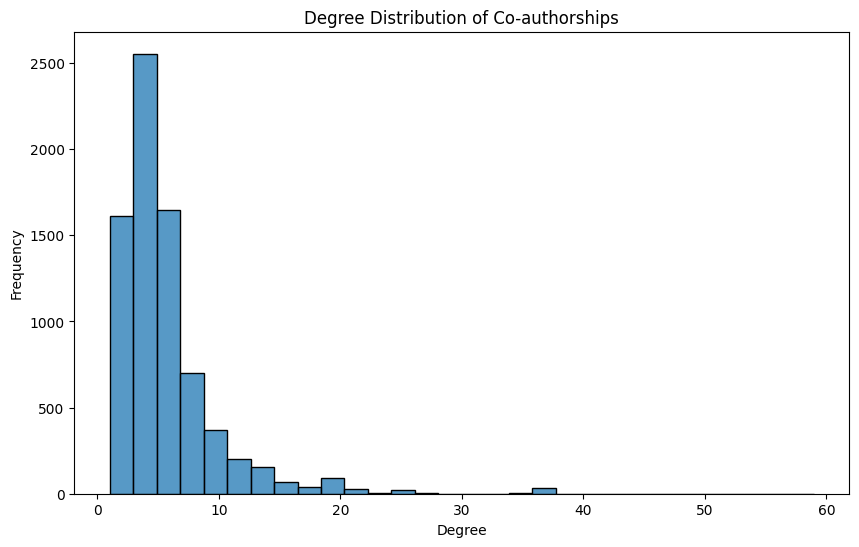

In [15]:
# Assuming G is your citation network graph
# Get a list of all degrees in the network
degrees = [deg for node, deg in G.degree()]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(degrees, bins=30, kde=False, stat="count")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Co-authorships")
plt.show()

In [17]:
# Statistical analysis for powerlaw fitting

# Step 1: Fit the power-law and other distributions
fit = powerlaw.Fit(degrees)

# Step 3: Compare power-law with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Power law vs. Exponential: R={R}, p={p}")

R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Power law vs. Lognormal: R={R}, p={p}")

R, p = fit.distribution_compare('power_law', 'truncated_power_law')
print(f"Power law vs. Truncated Power law: R={R}, p={p}")

Calculating best minimal value for power law fit
Power law vs. Exponential: R=138.69088379741615, p=1.532644460474922e-16
Power law vs. Lognormal: R=-0.06108431372821199, p=0.3895000033731909
Power law vs. Truncated Power law: R=-0.48852083906710453, p=0.3229302611305951


C:\Users\FerrariniL\AppData\Local\anaconda3\Lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


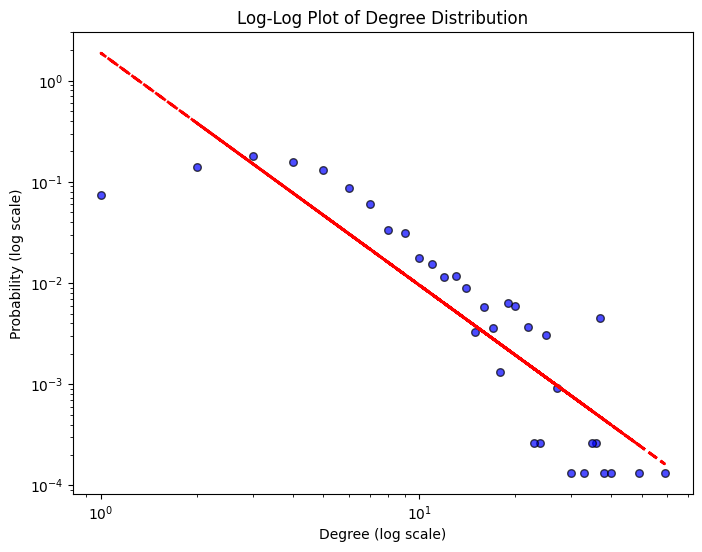

Slope: -2.2915863418536757, Intercept: 0.6256060814992532


In [19]:
# check for power-low distribution
# Step 1: Calculate degree frequencies
degree_counts = Counter(degrees)
degree, count = zip(*degree_counts.items())

# Normalize the counts to get the probability of each degree
count = np.array(count) / sum(count)

# Step 2: Plot on log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(degree, count, color="b", s=30, alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (log scale)")
plt.ylabel("Probability (log scale)")
plt.title("Log-Log Plot of Degree Distribution")

# Optional: add a line of best fit to visualize linearity
slope, intercept = np.polyfit(np.log(degree), np.log(count), 1)
plt.plot(degree, np.exp(intercept) * np.power(degree, slope), color="red", linestyle="--", linewidth=2)

plt.show()
print(f'Slope: {slope}, Intercept: {intercept}')

In [21]:
# Node degree (number of connections) can represent influence in the network
influential_authors = sorted(G.degree, key=lambda x: x[1], reverse=True)
print("Most influential papers:", influential_authors[:10])

Most influential papers: [('https://openalex.org/A5034690093', 59), ('https://openalex.org/A5034166335', 49), ('https://openalex.org/A5061907283', 40), ('https://openalex.org/A5008967340', 38), ('https://openalex.org/A5038457105', 37), ('https://openalex.org/A5000488576', 37), ('https://openalex.org/A5032294516', 37), ('https://openalex.org/A5028595319', 37), ('https://openalex.org/A5056017119', 37), ('https://openalex.org/A5002574344', 37)]


In [49]:
# Calculate node degree for each node in the network
node_degrees = dict(G.degree())

# Convert node degrees to a DataFrame for easier manipulation
degree_df = pd.DataFrame(list(node_degrees.items()), columns=['node', 'degree'])

# Sort by degree in descending order and select the top nodes
top_nodes = degree_df.sort_values(by='degree', ascending=False)['node']

# we want toc consider only the largest connected component
connected_components = list(nx.connected_components(G))

cc_size = []
for cc in connected_components:
    cc_size.append(len(cc))

cc_size.sort(reverse=True)
print(cc_size)

N = 1
sorted_components = sorted(connected_components, key=len, reverse=True)  # Sort by size, largest first
# Step 2: Retain the two largest components
top_N_components = sorted_components[:N]  # Get the two largest components

# Combine the two largest components into a subgraph
# Use unpacking (*) to pass each set in top_two_components as separate arguments to set.union
combined_nodes = set().union(*top_N_components)

# Step 3: Create a subgraph of the largest connected component
G_lcc = G.subgraph(combined_nodes).copy()

#print(G.number_of_nodes())
#print(G_lcc.number_of_nodes())

[883, 173, 51, 51, 43, 31, 29, 26, 26, 25, 25, 24, 23, 23, 23, 22, 21, 20, 20, 19, 19, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 16, 16, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6

In [151]:
# Let's create communities

# Step 1: Apply Louvain method for community detection
partition = community_louvain.best_partition(G_lcc)

# Step 2: Visualize the graph with community colors
values = [partition.get(node) for node in G_lcc.nodes()]

# Step 4: Create a force-directed layout
pos = nx.spring_layout(G_lcc, k=0.15, iterations=400)

In [152]:
# Get unique communities and map them to colors
unique_communities = set(values)
community_colors = {community: plt.cm.rainbow(i / len(unique_communities)) for i, community in enumerate(unique_communities)}

# Step 4: Create a list of handles and labels for the legend
handles = []
labels = []
for community, color in community_colors.items():
    # Create a patch for the legend with each community's color
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(f"Community {community}")

# Step 4: Display community-color mapping
print("Community to Color Mapping:")
for community, color in community_colors.items():
    print(f"Community {community}: {color}")

Community to Color Mapping:
Community 0: (0.5, 0.0, 1.0, 1.0)
Community 1: (0.4294117647058824, 0.11065268189150083, 0.9984636039674339, 1.0)
Community 2: (0.3588235294117647, 0.2199463578396686, 0.9938591368952737, 1.0)
Community 3: (0.28823529411764703, 0.3265387128400833, 0.9862007473534026, 1.0)
Community 4: (0.21764705882352942, 0.42912060877260894, 0.9755119679804366, 1.0)
Community 5: (0.1470588235294118, 0.5264321628773557, 0.961825643172819, 1.0)
Community 6: (0.07647058823529412, 0.6172782212897929, 0.9451838281608196, 1.0)
Community 7: (0.0019607843137254832, 0.7092813076058535, 0.9232891061054894, 1.0)
Community 8: (0.0725490196078431, 0.7829276104921027, 0.9005867023006374, 1.0)
Community 9: (0.14313725490196072, 0.846958210824467, 0.8751169828229928, 1.0)
Community 10: (0.21372549019607845, 0.9005867023006374, 0.8469582108244671, 1.0)
Community 11: (0.28431372549019607, 0.9431544344712774, 0.8161969123562217, 1.0)
Community 12: (0.3549019607843137, 0.9741386021045101, 0.7

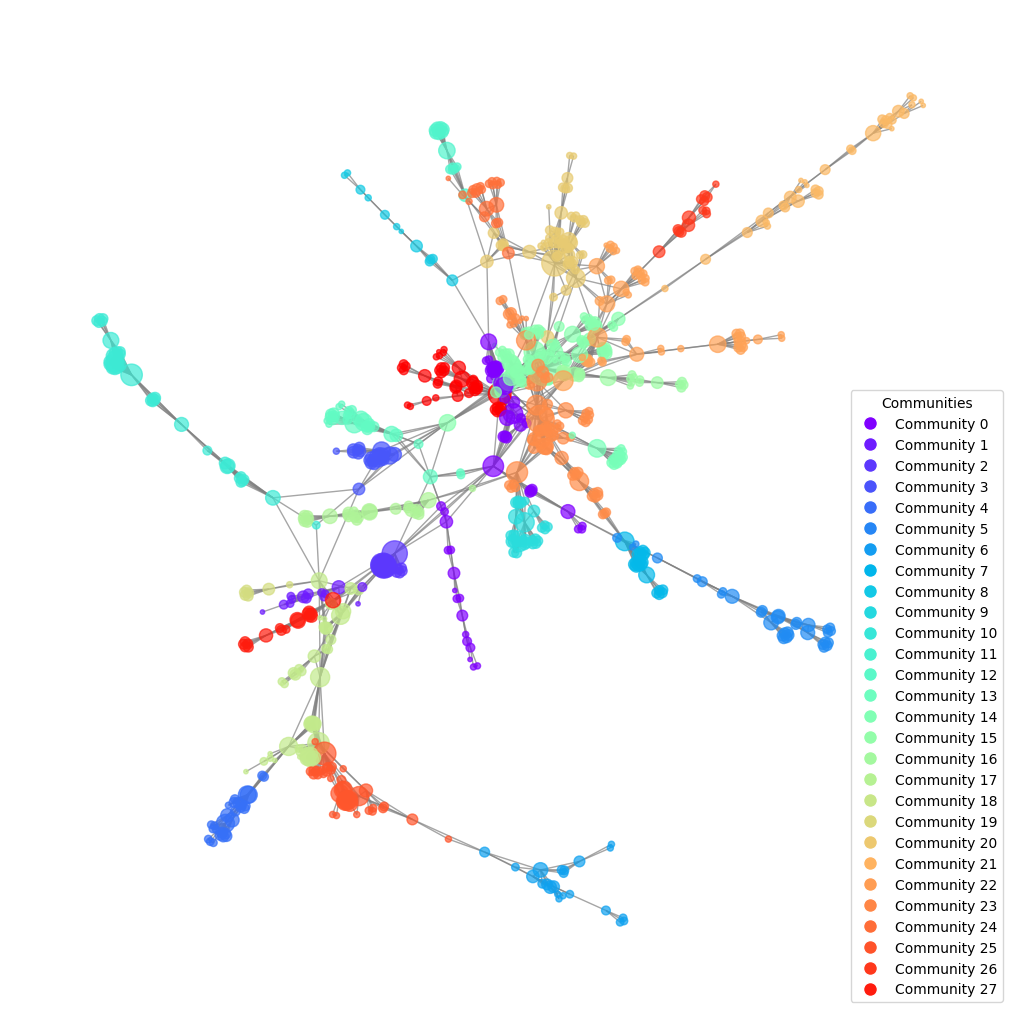

In [153]:
# Visualize the co-citation network

# Scale node sizes based on their degree in the original graph (before filtering)
node_sizes = [node_degrees[node] * 10 for node in G_lcc.nodes()]  # Multiply by 10 for visibility

plt.figure(figsize=(10, 10))  # Optional: Adjust figure size
nx.draw(G_lcc, pos, with_labels=False, node_size=node_sizes, node_color=values, cmap=plt.cm.rainbow, font_size=10, font_weight='bold', edge_color='gray', alpha=0.7)
# Add legend
plt.legend(handles=handles, labels=labels, title="Communities", loc="best", fontsize=10)
plt.show()

In [ ]:
# Now we want to see how institutions are distributed within each community.
# We also want to see how countries are distributed
# For this we use the metadata on the edges
# We do the same for countries

In [157]:
# Create a dictionary to store unique institutions for each partition
partition_institutions = {}

# Iterate through nodes in each partition
for node, comm in partition.items():
    if comm not in partition_institutions:
        partition_institutions[comm] = set()
    
    # Get edges connected to this node
    for neighbor in G_lcc.neighbors(node):
        # Add institution data from the edge metadata
        edge_data = G_lcc.get_edge_data(node, neighbor)
        if edge_data:            
            partition_institutions[comm].add(edge_data.get("firstInstitute"))
            partition_institutions[comm].add(edge_data.get("secondInstitute"))

# Convert the sets to lists (optional) for easier readability or further processing
partition_institutions = {k: list(v) for k, v in partition_institutions.items()}

# Now for countries
partition_countries = {}

# Iterate through nodes in each partition
for node, comm in partition.items():
    if comm not in partition_countries:
        partition_countries[comm] = set()
    
    # Get edges connected to this node
    for neighbor in G_lcc.neighbors(node):
        # Add institution data from the edge metadata
        edge_data = G_lcc.get_edge_data(node, neighbor)
        if edge_data:            
            partition_countries[comm].add(edge_data.get("firstCountry"))
            partition_countries[comm].add(edge_data.get("secondCountry"))

# Convert the sets to lists (optional) for easier readability or further processing
partition_countries = {k: list(v) for k, v in partition_countries.items()}

In [159]:
# Print results
for comm, institutions in partition_institutions.items():
    print(f"Partition {comm}: {institutions}")

for comm, countries in partition_countries.items():
    print(f"Partition {comm}: {countries}")

Partition 27: ['China Ocean Shipping (China)', 'Wuhan University of Technology', 'University of Zagreb', 'University of Tennessee at Knoxville', 'Tianjin University', 'Tianjin University of Science and Technology', 'University of California, Santa Barbara', 'Dalian Maritime University', 'Aalto University', 'Liverpool John Moores University', 'National University of Singapore', 'Nanyang Technological University', 'Nahrain University', 'Sanya University', nan, 'China University of Geosciences', 'State Key Laboratory of Information Engineering in Surveying Mapping and Remote Sensing', 'Harbin Engineering University', 'Wuhan University', 'China Railway Fifth Survey and Design Institute Group']
Partition 1: ['University of Tasmania', 'Gdańsk University of Technology', 'Iran University of Science and Technology', 'Kotka Maritime Research Centre', nan, 'Gdynia Maritime University', 'Dalhousie University', 'Imam Abdulrahman Bin Faisal University']
Partition 6: ['Singapore University of Technol

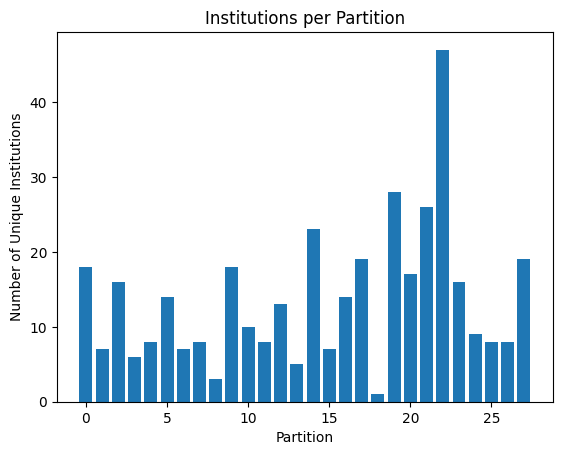

In [163]:
# Initialize a dictionary to store institutions per partition
institutions_per_partition = {}

# Loop through each node and its community in the partition
for node, community in partition.items():
    institutions = set()

    # Iterate through neighbors to collect 'firstInstitute' and 'secondInstitute' values
    for neighbor in G_lcc.neighbors(node):
        # Get 'firstInstitute' and check if it's not NaN
        first_institute = G_lcc[node][neighbor].get('firstInstitute')
        if pd.notna(first_institute):  # Only add if it's not NaN
            institutions.add(first_institute)

        # Get 'secondInstitute' and check if it's not NaN
        second_institute = G_lcc[node][neighbor].get('secondInstitute')
        if pd.notna(second_institute):  # Only add if it's not NaN
            institutions.add(second_institute)

    # Update the institutions_per_partition dictionary
    institutions_per_partition[community] = institutions_per_partition.get(community, set()).union(institutions)

# Calculate the number of unique institutions per partition
partition_sizes = {k: len(v) for k, v in institutions_per_partition.items()}

# Plot the distribution of unique institutions across partitions
plt.bar(partition_sizes.keys(), partition_sizes.values())
plt.xlabel('Partition')
plt.ylabel('Number of Unique Institutions')
plt.title('Institutions per Partition')
plt.show()

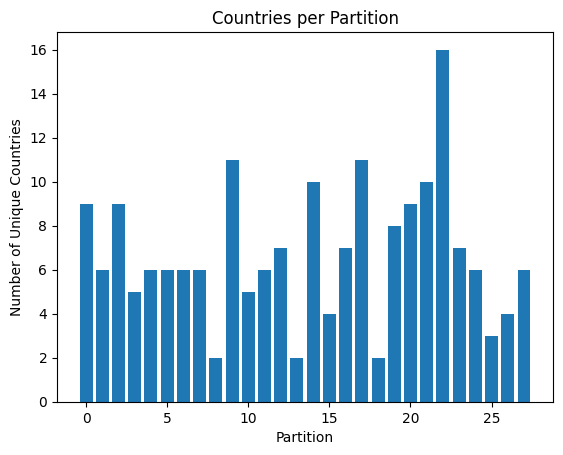

In [165]:
# Initialize a dictionary to store countries per partition
countries_per_partition = {}

# Loop through each node and its community in the partition
for node, community in partition.items():
    countries = set()  

    # Iterate through neighbors to collect 'firstInstitute' and 'secondInstitute' values
    for neighbor in G_lcc.neighbors(node):
        # Get 'firstInstitute' and check if it's not NaN
        first_country = G_lcc[node][neighbor].get('firstCountry')
        if pd.notna(first_country):  # Only add if it's not NaN
            countries.add(first_country)

        # Get 'secondInstitute' and check if it's not NaN
        second_country = G_lcc[node][neighbor].get('secondCountry')
        if pd.notna(second_country):  # Only add if it's not NaN
            countries.add(second_institute)

    # Update the countries_per_partition dictionary
    countries_per_partition[community] = countries_per_partition.get(community, set()).union(countries)

# Calculate the number of unique countries per partition
partition_sizes = {k: len(v) for k, v in countries_per_partition.items()}

# Plot the distribution of unique countries across partitions
plt.bar(partition_sizes.keys(), partition_sizes.values())
plt.xlabel('Partition')
plt.ylabel('Number of Unique Countries')
plt.title('Countries per Partition')
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
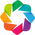

:Chord   [Source,Target]   (Weight)

In [167]:
hv.extension('bokeh')


# Placeholder for the data extraction
institution_links = defaultdict(int)

# Iterate through edges in the graph
for u, v, data in G_lcc.edges(data=True):
    first_institute = data.get('firstInstitute', None)
    second_institute = data.get('secondInstitute', None)
    
    # Skip edges with missing institutions (None or NaN)
    if pd.isna(first_institute) or pd.isna(second_institute) or first_institute is None or second_institute is None:
        continue

    # Convert to strings if necessary (ensure non-null and non-NaN)
    first_institute = str(first_institute)
    second_institute = str(second_institute)
    
    # Sort to ensure consistent key order (Institution A -> Institution B is the same as Institution B -> Institution A)
    sorted_pair = tuple(sorted([first_institute, second_institute]))
    
    # Increment count for the institution pair
    institution_links[sorted_pair] += 1

# Convert to a DataFrame for visualization
data = [(k[0], k[1], v) for k, v in institution_links.items()]
df = pd.DataFrame(data, columns=['Source', 'Target', 'Weight'])

chord = hv.Chord(df)

# Add options to customize appearance
chord.opts(
    opts.Chord(
        width=1000,
        height=1000,
        labels='Source', 
        cmap='Category20', 
        edge_color='Weight', 
        node_color='Source',
        edge_cmap='viridis', 
        title="Chord Diagram of Institutions"
    )
)

# Display the chord diagram
chord

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
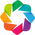

:Chord   [Source,Target]   (Weight)

In [169]:
hv.extension('bokeh')


# Placeholder for the data extraction
country_links = defaultdict(int)

# Iterate through edges in the graph
for u, v, data in G_lcc.edges(data=True):
    first_c = data.get('firstCountry', None)
    second_c = data.get('secondCountry', None)
    
    # Skip edges with missing institutions (None or NaN)
    if pd.isna(first_c) or pd.isna(second_c) or first_c is None or second_c is None:
        continue

    # Convert to strings if necessary (ensure non-null and non-NaN)
    first_c = str(first_c)
    second_c = str(second_c)
    
    # Sort to ensure consistent key order (Institution A -> Institution B is the same as Institution B -> Institution A)
    sorted_pair = tuple(sorted([first_c, second_c]))
    
    # Increment count for the institution pair
    country_links[sorted_pair] += 1

# Convert to a DataFrame for visualization
data = [(k[0], k[1], v) for k, v in country_links.items()]
df = pd.DataFrame(data, columns=['Source', 'Target', 'Weight'])

chord = hv.Chord(df)

# Add options to customize appearance
chord.opts(
    opts.Chord(
        width=1000,
        height=1000,
        labels='Source', 
        cmap='Category20', 
        edge_color='Weight', 
        node_color='Source',
        edge_cmap='viridis', 
        title="Chord Diagram of Countries"
    )
)

# Display the chord diagram
chord

In [183]:
# To conclude, we assess small-world properties of co-authorships

# Calculate the average clustering coefficient
avg_clustering = nx.average_clustering(G_lcc)
print(f"Average Clustering Coefficient: {avg_clustering}")

# Calculate the average path length (only if the graph is connected)
if nx.is_connected(G_lcc):
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    print(f"Average Path Length: {avg_path_length}")
else:
    print("Graph is not connected, cannot calculate average path length.")

# Generate a random graph with the same number of nodes and edges
def generate_connected_random_graph(num_nodes, num_edges):
    # Keep generating until we get a connected graph
    while True:
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        if nx.is_connected(random_graph):
            return random_graph
            
# Generate a random connected graph with the same number of nodes and edges
random_graph = generate_connected_random_graph(G_lcc.number_of_nodes(), G_lcc.number_of_edges())

# Calculate the average clustering coefficient of the random graph
avg_clustering_random = nx.average_clustering(random_graph)
print(f"Average Clustering Coefficient (Random Graph): {avg_clustering_random}")

# Calculate the average path length of the random graph (only if it is connected)
if nx.is_connected(random_graph):
    avg_path_length_random = nx.average_shortest_path_length(random_graph)
    print(f"Average Path Length (Random Graph): {avg_path_length_random}")
else:
    print("Random Graph is not connected, cannot calculate average path length.")

# Interesting finding on average path and what that means for the communities

Average Clustering Coefficient: 0.8299556799830806
Average Path Length: 7.058751473409296
Average Clustering Coefficient (Random Graph): 0.008818374277037914
Average Path Length (Random Graph): 3.9132980485512436
